In [1]:
%load_ext autoreload
%autoreload 2

# Interpolating between genetic circuits

In looking for a specific level of adaptation, can we just interpolate between circuits of known adaptation values?

In [19]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from common import set_theme
set_theme()

from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation


# Load dataset 

Ideally, use a sequence-sampled dataset so that we can comment on interpolating sequences.


In [3]:
dir_sim = 'data/simulate_circuits/2025_09_23__15_41_51'
fn_circuits = '../data/raw/generate_sequence_batch/2025_09_20_103744/circuits/rc.json'
fn_energies = '../data/raw/generate_sequence_batch/2025_09_20_103744/energies.json'
fn_analytics = os.path.join(dir_sim, 'analytics.json')

# with open(fn_circuits, 'r') as f:
#     circuits = json.load(f)
with open(fn_energies, 'r') as f:
    energies = json.load(f)
with open(fn_analytics, 'r') as f:
    analytics = json.load(f)

energies = pd.DataFrame.from_dict(energies)

In [4]:
analytics = {k: np.array(v) for k, v in analytics.items()}
analytics['adaptation'] = calculate_adaptation(analytics['sensitivity'], analytics['precision'], alpha=2)


# Pick 2 circuits to compare

In [35]:
n = 3
idx_species = -1
# species = [f'$RNA_{"".join(str(i+1)+str(j+1))}$' for i,
#            j in zip(*np.triu_indices(n))] + [f'RNA_{i+1}' for i in range(n)]
# cols_e = [f'$RNA_{i+1}$-$RNA_{j+1}$' for i, j in zip(*np.triu_indices(n))]

subset_idxs = np.array(energies[energies.sum(
    axis=1) < -2].index.astype(int).tolist())
subset_adaptable = np.where((analytics['sensitivity'][subset_idxs, idx_species] >= 1) & (
    analytics['precision'][subset_idxs, idx_species] >= 10))[0]

len(subset_idxs), len(energies)

(564653, 1000000)

Partially load timeseries

In [36]:
ts = np.load(os.path.join(dir_sim, 'ts.npy'))
# ys = np.load(os.path.join(dir_sim, 'ys.npy'))[subset_idxs, ..., idx_species]
ys_memmap = np.lib.format.open_memmap(os.path.join(dir_sim, 'ys.npy'), mode='r+')
ys = ys_memmap[subset_idxs, :, idx_species]

array([0.1392653 , 0.06340027, 0.8317523 , 0.21474838, 0.68702817,
       0.07582951, 0.43959618, 0.61970782, 0.13767576, 0.46374798,
       0.41254306, 0.08102655, 0.1260252 , 0.71118212, 0.80384254,
       0.77644444, 0.34614754, 0.43028641, 0.16598272])

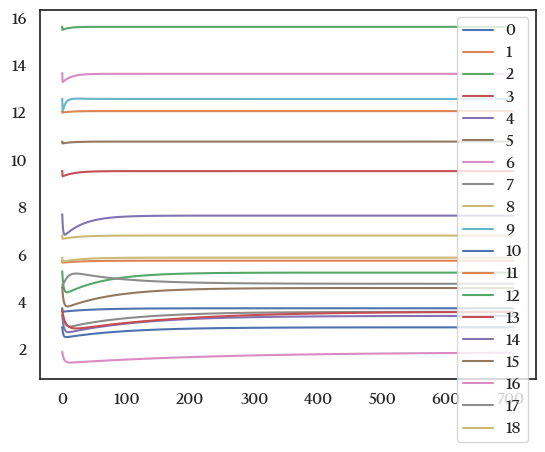

In [52]:
tmax = 800
tmax_idx = np.where(ts <= tmax)[0][-1]
plt.plot(ts[:tmax_idx], ys[subset_adaptable][:, :tmax_idx].T)
plt.legend(np.arange(len(subset_adaptable)))

analytics['overshoot'][subset_idxs[subset_adaptable], idx_species]

^I like the 3rd adaptable circuit here

In [53]:
analytics['overshoot'][subset_idxs[subset_adaptable], idx_species][2]
idx_circ1 = subset_adaptable[2]
energies.iloc[subset_idxs].iloc[idx_circ1]

energies_0    -6.70
energies_1     0.00
energies_2    -9.24
energies_3     0.00
energies_4     0.00
energies_5   -16.38
Name: 166418, dtype: float64

Going to choose the 2nd circuit based medium-level adpatation.

In [70]:
def calc_absolute_level(analytic, relative_level):
    return np.nanmin(analytic) + relative_level * (np.nanmax(analytic) - np.nanmin(analytic))

k = 'adaptation'
level = 0.8
v = np.array(analytics[k])[subset_idxs, idx_species]
idx_circ2 = np.where(v >= calc_absolute_level(v, level))[0][0]
for k in ['adaptation', 'sensitivity', 'precision']:
    print(k, '\t', analytics[k][subset_idxs[idx_circ2], idx_species])



adaptation 	 845.47046
sensitivity 	 0.27472123503685
precision 	 14.472169876098633


In [71]:
energies.iloc[subset_idxs].iloc[idx_circ2]

energies_0     0.00
energies_1     0.00
energies_2     0.00
energies_3     0.00
energies_4    -4.05
energies_5   -13.62
Name: 3, dtype: float64

In [72]:
# [circuits[f'RNA_{i}'][str(idx_circ_upper[0])] for i in np.arange(n)]

In [74]:
circuit1 = energies.iloc[subset_idxs].iloc[idx_circ1].values
circuit2 = energies.iloc[subset_idxs].iloc[idx_circ2].values

circuit1, circuit2

(array([ -6.7 ,   0.  ,  -9.24,   0.  ,   0.  , -16.38]),
 array([  0.  ,   0.  ,   0.  ,   0.  ,  -4.05, -13.62]))

# Interpolate between the 2 circuits to make 100 new circuits


Hmm not sure what makes the most here... will come back to it later.


In [ ]:




# Simulate the new circuits


# Visualise the adaptation level over the interpolation
# This could be a heatmap of 6 columns (binding energy) and 100 rows (circuits)
# Have an extra column showing the relative adaptation level of each circuit


# Visualise the interpolation in a dimensionality reduced space